In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from IPython.display import display, display_html, HTML
from functools import partial
import pprint
import requests
import pickle
import json
import os

# Scikit-learn imports
from sklearn.metrics import (
    confusion_matrix, auc, roc_curve, roc_auc_score, 
    classification_report, ConfusionMatrixDisplay, 
    RocCurveDisplay, accuracy_score, precision_score, 
    recall_score, f1_score, make_scorer
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedShuffleSplit, 
    GridSearchCV, cross_val_predict, StratifiedKFold
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_sample_weight
from sklearn.base import BaseEstimator, TransformerMixin


# Set max columns and rows to display
pd.set_option('display.max_columns', 500)

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data/two-years-recid.csv')

print(df.shape)
df.head()

(6114, 35)


,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [3]:
df.columns

Index(['id', 'name', 'sex', 'dob', 'age', 'race', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_charge_degree',
       'c_charge_desc', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'compas_screening_date', 'type_of_assessment',
       'decile_score', 'score_text', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'is_recid', 'r_case_number', 'r_offense_date',
       'r_charge_degree', 'r_charge_desc', 'is_violent_recid',
       'vr_case_number', 'vr_offense_date', 'vr_charge_degree',
       'vr_charge_desc', 'two_year_recid'],
      dtype='object')

In [4]:
selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in", "is_recid"]

df = df[selected_columns]

df.head()

,id,name,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_case_number,c_charge_degree,c_charge_desc,c_offense_date,c_arrest_date,c_jail_in,is_recid
0,1,steven lux,Male,1953-06-15,Caucasian,0,0,0,0,13000208CF10A,F,False Imprisonment,2013-01-05,NaN,2013-01-05 04:35:31,0
1,2,andre small,Male,1987-10-01,African-American,0,0,0,1,13006354MM10A,M,Battery,2013-04-02,NaN,2013-04-02 12:18:46,0
2,3,willie gray,Male,1959-01-12,African-American,0,0,0,8,14040148MU10A,M,DUI Level 0.15 Or Minor In Veh,2014-10-30,NaN,2014-10-31 12:02:01,1
3,4,nickson marcellus,Male,1996-07-11,African-American,0,1,0,1,13017969CF10A,F,arrest case no charge,NaN,2014-01-23,2014-01-23 03:19:30,1
4,5,patria barnes,Female,1978-06-06,Other,0,0,0,0,13022717MM10A,M,Battery,2013-12-07,NaN,2013-12-08 01:55:28,0


In [6]:
# describe date columns compute min,max,average,median
date_columns = ['c_offense_date', 'c_arrest_date', 'c_jail_in']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
df[date_columns].describe()

# show median values for date columns
df[date_columns].median()

c_offense_date   2013-08-25 00:00:00.000
c_arrest_date    2013-07-02 00:00:00.000
c_jail_in        2013-09-13 02:36:35.500
dtype: datetime64[ns]

In [26]:
for feat in df.columns:
    print(feat)

id
name
sex
dob
race
juv_fel_count
juv_misd_count
juv_other_count
priors_count
c_case_number
c_charge_degree
c_charge_desc
c_offense_date
c_arrest_date
c_jail_in
is_recid


In [24]:
# Define FeatureCreation class
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = [
            "id", "name", "sex", "dob", "race",
            "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count",
            "c_case_number", "c_charge_degree", "c_charge_desc", "c_offense_date",
            "c_arrest_date", "c_jail_in"
        ]
    
    def fit(self, X, y=None):
        # This method doesn't need to do anything for this transformer
        return self
    
    def transform(self, X):
        # Make a copy of the dataframe to avoid modifying the original input
        df = X.copy()
        
        # Convert dates to datetime
        df['dob'] = pd.to_datetime(df['dob'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

        # Age Calculation as an integer
        df['age_at_arrest'] = (df['c_jail_in'] - df['dob']).dt.days // 365

        # Age group
        age_bins = [0, 24, 34, 44, 54, 100]
        age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
        df['age_group'] = pd.cut(df['age_at_arrest'], bins=age_bins,
                                 labels=age_labels, right=False)

        # Replace c_charge_degree
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('F', 'Felony')
        df['c_charge_degree'] = df['c_charge_degree'].str.replace('M', 'Misdemeanor')
        df['c_charge_degree'] = df['c_charge_degree'].fillna('Missing')
        
        # Calculate sample weights chosen
        df['weights_race'] = compute_sample_weight(class_weight='balanced', y=df['race'])
        
        # Drop unnecessary columns
        df = df.drop(['dob', 'c_case_number', 'c_charge_desc', 'c_offense_date', 'c_arrest_date', 'name', 'c_jail_in', 'age_at_arrest'], axis=1)

        return df

In [27]:
df_processed = FeatureCreation().fit_transform(df).set_index('id')

df_processed.head()

for feature in df_processed.columns:
    print(feature)

sex
race
juv_fel_count
juv_misd_count
juv_other_count
priors_count
c_charge_degree
is_recid
age_group
weights_race


In [9]:
# Create an instance of the FeatureCreation class


# Split the data into features (X) and target (y)
X = df_processed.drop(columns=['is_recid','weights_race'])
y = df['is_recid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Define the logistic regression classifier
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Define the pipeline
pipe_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_baseline)
])

# Fit the pipeline with weights
sample_weights = df_processed.loc[X_train.index, 'weights_race']
# Fit the pipeline with weights
pipe_baseline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

y_pred_baseline = pipe_baseline.predict(X_test)

In [10]:
# show weight for each class sorted by class label
df_processed[['race','weights_race']].groupby('race').mean().sort_values('weights_race',ascending=False).style.format("{:.2f}").background_gradient(cmap='viridis')

,weights_race
race,
Native American,78.38
Asian,39.19
Other,3.14
Hispanic,1.87
Caucasian,0.49
African-American,0.33


In [11]:
# Transform the data using the pipeline
X_train_transformed = pipe_baseline.named_steps['preprocessor'].transform(X_train)

# Get the transformed numerical columns
num_cols_transformed = pipe_baseline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=num_cols)

# Get the transformed categorical columns
cat_cols_transformed = pipe_baseline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=cat_cols)

# Combine numerical and categorical transformed columns
columns_transformed = list(num_cols_transformed) + list(cat_cols_transformed)

# Create a DataFrame with transformed data
X_train_transformed = pd.DataFrame(X_train_transformed, columns=columns_transformed)

# Display the transformed DataFrame
X_train_transformed.head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_Felony,c_charge_degree_Misdemeanor,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55+,age_group_<25
0,-0.166508,-0.190829,1.991071,-0.497269,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.166508,-0.190829,-0.225712,0.123915,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.166508,-0.190829,-0.225712,-0.704330,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.166508,-0.190829,-0.225712,-0.497269,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.166508,-0.190829,-0.225712,-0.497269,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


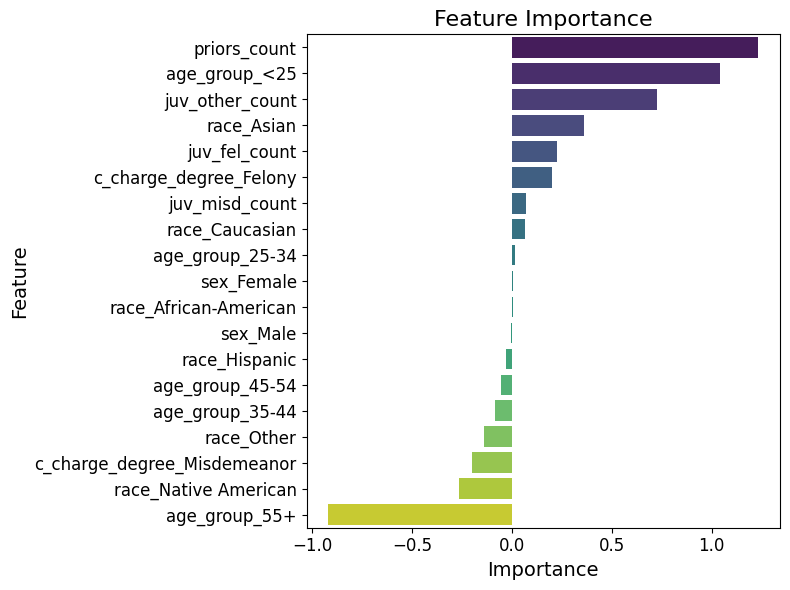

In [12]:
# Feature importance from the classifier
feature_importance = pipe_baseline.named_steps['classifier'].coef_[0]

# Get the feature names from the preprocessor
num_cols_feature = pipe_baseline.named_steps['preprocessor'].transformers_[0][2]
cat_cols_feature = pipe_baseline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=cat_cols).tolist()

# Combine feature names and importances
feature_names = num_cols_feature + cat_cols_feature
feature_importance_combined = list(feature_importance[:len(num_cols_feature)]) + list(feature_importance[len(num_cols_feature):])  # Splitting feature_importance for numerical and categorical features

# Create a DataFrame to display feature names and importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_combined})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance with improved visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
print(X.columns)
print(X.dtypes)

Index(['sex', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'age_group'],
      dtype='object')
sex                  object
race                 object
juv_fel_count         int64
juv_misd_count        int64
juv_other_count       int64
priors_count          int64
c_charge_degree      object
age_group          category
dtype: object


In [14]:
pipe_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sex', 'race',
                                                   'c_charge_degree',
                                                   'age_group'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [21]:
# Pickle the fitted pipeline into a file named pipeline.pickle
with open(os.path.join('data', 'pipeline.pickle'), 'wb') as fh:
    pickle.dump(pipe_baseline, fh)


# Serialize the column names from the X DataFrame into a file named columns.json
with open(os.path.join('data', 'columns.json'), 'w') as fh:
    json.dump(X.reset_index().columns.tolist(), fh)
    

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
with open(os.path.join('data', 'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X.reset_index().dtypes, fh)
    


In [22]:
# assert that the pipeline is working as expected
# Load the pipeline from the file
with open(os.path.join('data', 'pipeline.pickle'), 'rb') as fh:
    loaded_pipe = pickle.load(fh)

# assert that the column names are the same
# Load the column names from the file
with open(os.path.join('data', 'columns.json'), 'r') as fh:
    loaded_columns = json.load(fh)

with open(os.path.join('data', 'dtypes.pickle'), 'rb') as fh:
    loaded_dtypes = pickle.load(fh)

In [23]:
print(loaded_columns)
print(loaded_dtypes)

['id', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'age_group']
id                    int64
sex                  object
race                 object
juv_fel_count         int64
juv_misd_count        int64
juv_other_count       int64
priors_count          int64
c_charge_degree      object
age_group          category
dtype: object


In [24]:
# predict using the loaded pipeline
y_pred_loaded = loaded_pipe.predict(X_test)

y_pred_loaded

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

`{
    "id": 6115,
    "name": "joseph amato",
    "sex": "Male",
    "dob": "1987-06-21",
    "race": "Caucasian",
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "priors_count": 1,
    "c_case_number": "13022428MM10A",
    "c_charge_degree": "M",
    "c_charge_desc": "Driving Under The Influence",
    "c_offense_date": "2013-12-02",
    "c_arrest_date": "2013-08-19",
    "c_jail_in": "2013-12-02 06:06:0"
}`